In [16]:
from pathlib import Path
import pickle
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.transforms import blended_transform_factory
import seaborn as sns

import trompy as tp

import os

colors_PVH = "#219C90"
colors_VMH  = "#90219c"

cmap = "RdBu_r"
# cmap = "BrBG"
# cmap = "PiYG"

In [3]:
DATAFOLDER = Path("C:/Data/hislight_pickles/")

with open(DATAFOLDER / "restricted_dark_full_data.pickle", 'rb') as handle:
    PVH_restricted = pickle.load(handle)
    
with open(DATAFOLDER / "HL3_restricted_dark_with_uv.pickle", 'rb') as handle:
    VMH_restricted = pickle.load(handle)    
    

In [13]:
def get_list_of_mice(data):

    mice_to_exclude = ["HL313", "HL314", "HL315", "HL316", "HL317", "HL318", "HL306", "HL308",
                        "HL202", "HL205", "HL206", "HL211",
                        "HL301", "HL304", "HL305"]
    
    #"HL202", "HL205", "HL206", "HL211" have poor placements without virus in PVH
    #HL 306, 308 have no virus
    #HL301, HL304, HL305 have poor fiber placement
    #HL313 - HL318 are control mice
    
    list_of_mice = []

    for key, val in data.items():
        if val["mouse_ID"] not in list_of_mice and val["mouse_ID"] not in mice_to_exclude:
            list_of_mice.append(val["mouse_ID"])
            
    return list_of_mice

In [6]:
def bin_snip(snip, nbins=40):

    old_length = len(snip)
    new_length = (old_length // nbins) * nbins  # Make sure the length is divisible by nbins
    
    # Clip the signal to make the length divisible by nbins
    clipped_snip = snip[:new_length]
    
    # Reshape to 2D (nbins, -1) and average across the second dimension
    reshaped_snip = np.reshape(clipped_snip, (nbins, -1))
    
    # Average along axis=1 (across each bin)
    snip_to_return = np.mean(reshaped_snip, axis=1)
    
    return snip_to_return

In [7]:
def process_session(data, session_key, nbins=25):

    # Extract blue, UV, and sampling frequency for the session
    blue = data[session_key]["blue"]
    uv = data[session_key]["uv"]
    fs = data[session_key]["fs"]  # Sampling frequency
    
    # Convert sample indices to time in minutes
    time_minutes = np.arange(len(blue)) / fs / 60  # time in minutes
    
    # Determine indices for cutting off first 2 minutes and last 2 minutes
    start_cutoff_index = int(3 * fs * 60)  # 2 minutes in samples
    end_cutoff_index = int(len(blue) - 3 * fs * 60)  # 2 minutes from the end
    
    # Slice the data to remove the first 2 and last 2 minutes
    blue_cut = blue[start_cutoff_index:end_cutoff_index]
    uv_cut = uv[start_cutoff_index:end_cutoff_index]
    
    # Update the time vector for the sliced data
    time_minutes_cut = time_minutes[start_cutoff_index:end_cutoff_index]

    # Create figure for plotting
    f,ax=plt.subplots(figsize=(12,4), ncols=3)

    
    # 1. Plot blue and UV light intensities with the updated time (cut off the first and last 2 minutes)
    ax[0].plot(time_minutes_cut, blue_cut, label="Blue Light", color='blue')
    ax[0].plot(time_minutes_cut, uv_cut, label="UV Light", color='purple')
    ax[0].set_title(f"{session_key} (after cutting 2 min)")
    ax[0].set_xlabel("Time (minutes)")
    ax[0].set_ylabel("Intensity")

    # Compute corrected signal (Z-score)
    correctedSignal = tp.processdata(blue_cut, uv_cut)
    
    # Compute mean and standard deviation for Z-score
    mean = np.mean(correctedSignal)
    std = np.std(correctedSignal)
    
    # Compute the Z-score
    z = (correctedSignal - mean) / std
    
    # 2. Plot Z-score
    ax[1].plot(z, label="Z-score", color='orange')
    ax[1].hlines([0], 0, len(z), linestyles='dashed', colors='green')
    ax[1].set_title(f"Z-score of Corrected Signal")
    ax[1].set_xlabel("Time (samples)")
    ax[1].set_ylabel("Z-score")
    
    # Smooth the Z-score using binning
    smoothed_z = bin_snip(z, nbins=nbins)
    
    # 3. Plot the binned (smoothed) Z-score
    ax[2].plot(smoothed_z, label="Binned Z-score", color='orange')
    ax[2].hlines([0], 0, len(smoothed_z), linestyles='dashed', colors='green')
    ax[2].set_title(f"Binned Z-score")
    ax[2].set_xlabel("Time (binned)")
    ax[2].set_ylabel("Z-score")

    plt.tight_layout(pad=2)
    
    return f

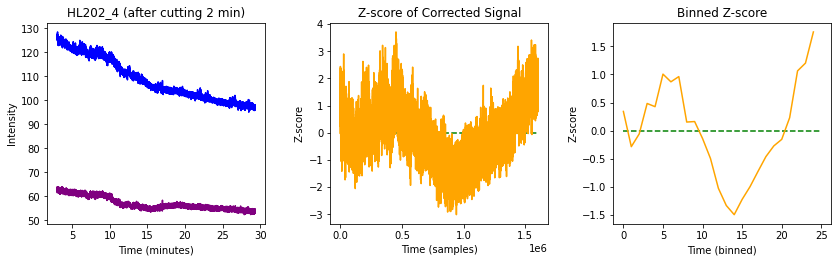

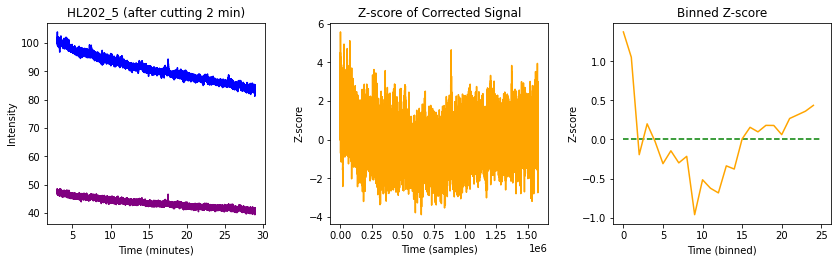

In [117]:
session_keys = ["HL202_4", "HL202_5"]  # Add more session keys as needed
for session_key in session_keys:
    process_session(data, session_key, nbins=25)

In [8]:
FIGSFOLDER = Path("C:/Users/kvo019/OneDrive - UiT Office 365/Pipette 2/People/Linnea/Manuscripts/hislight paper/other/whole_session_test")

Processing sessions for mouse HL203
Processing session HL203_4
Processing session HL203_5
Processing session HL203_6
Processing sessions for mouse HL204
Processing session HL204_4
Processing session HL204_5
Processing session HL204_6
Processing sessions for mouse HL207
Processing session HL207_4
Processing session HL207_5
Processing session HL207_6
Processing sessions for mouse HL208
Processing session HL208_4
Processing session HL208_5
Processing session HL208_6
Processing sessions for mouse HL209
Processing session HL209_4
Processing session HL209_5
Processing session HL209_6
Processing sessions for mouse HL210
Processing session HL210_4
Processing session HL210_5
Processing session HL210_6
Processing sessions for mouse HL212
Processing session HL212_4
Processing session HL212_5
Processing session HL212_6


<ipython-input-116-f36651c0c695>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(figsize=(12,4), ncols=3)


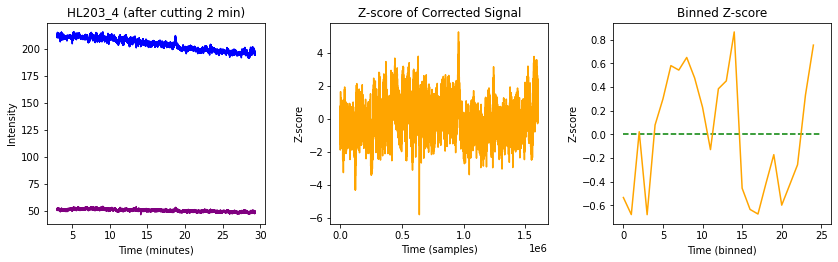

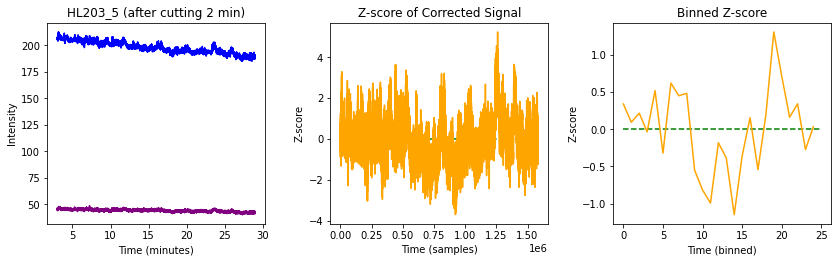

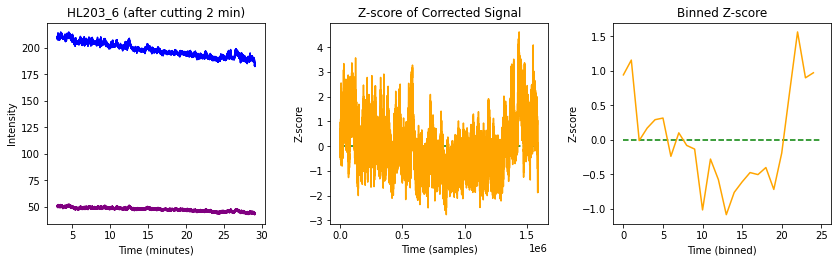

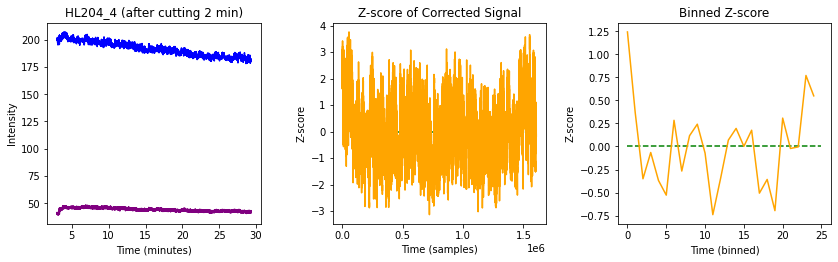

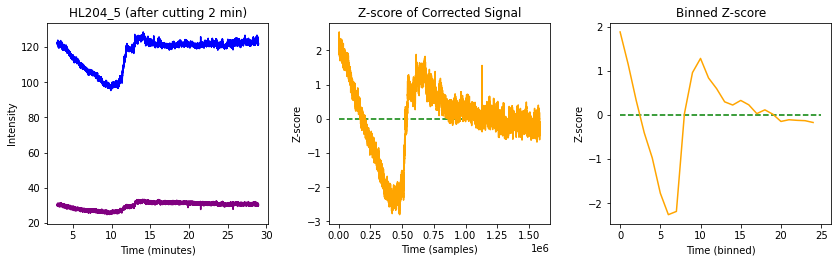

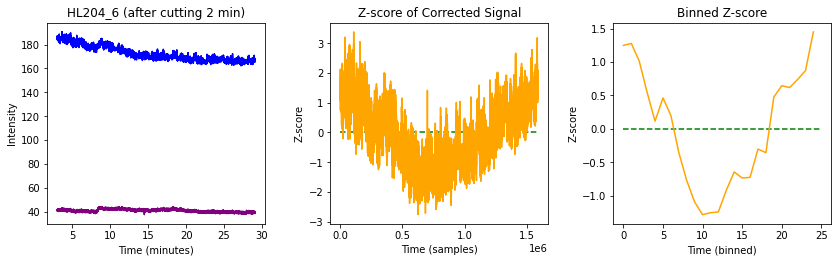

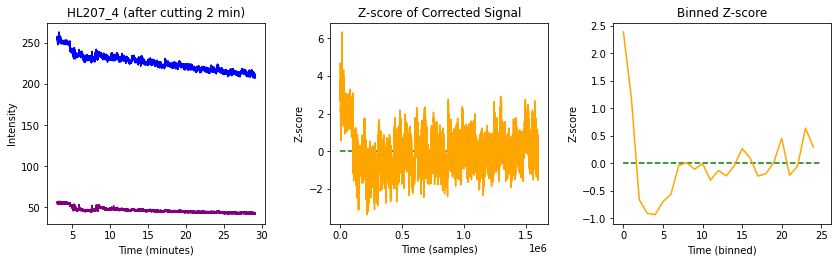

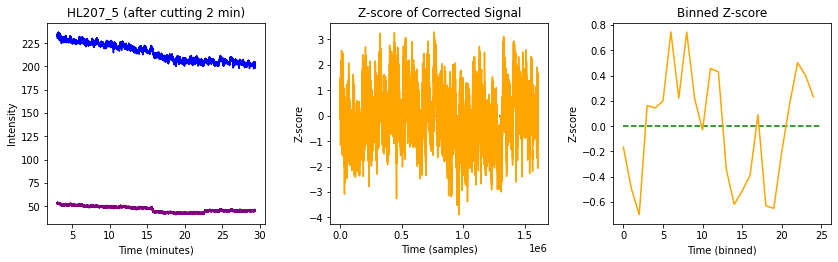

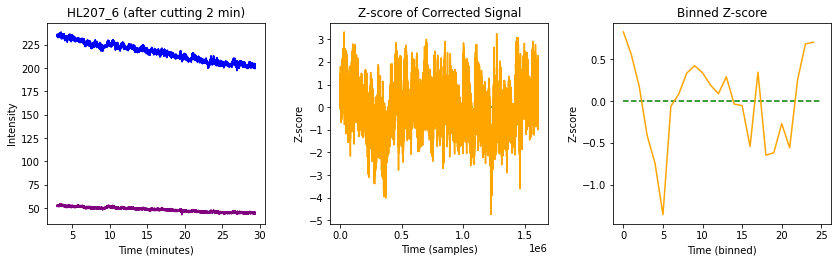

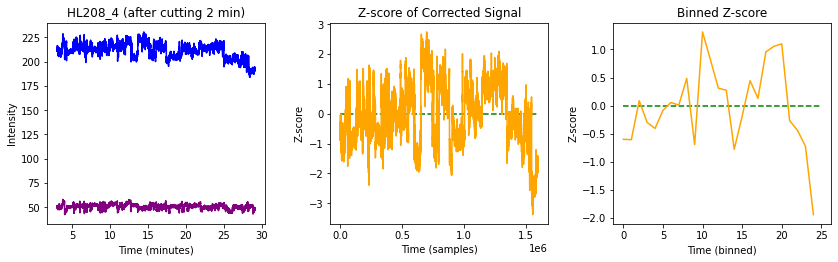

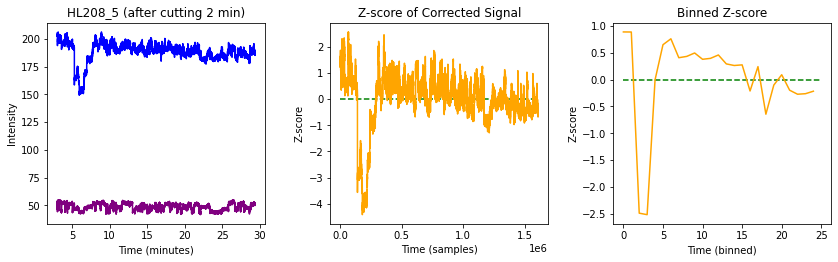

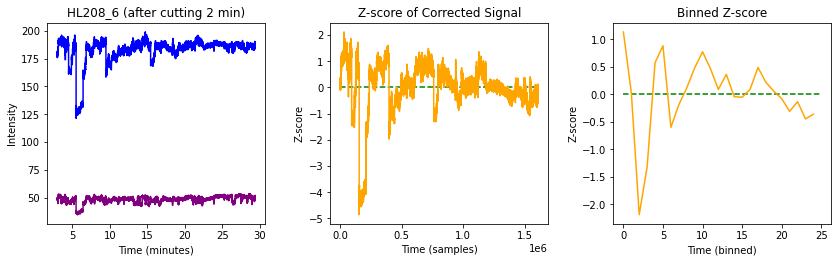

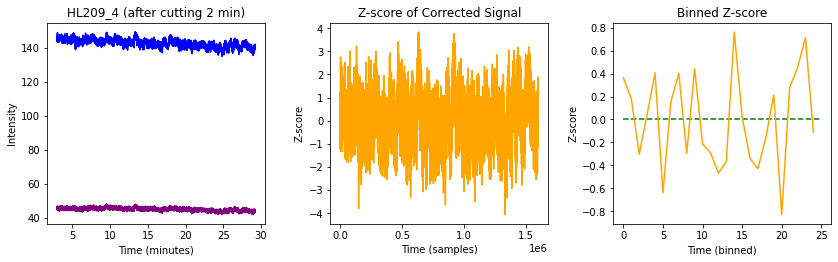

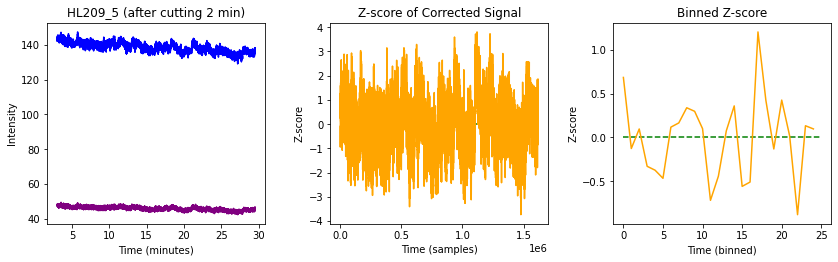

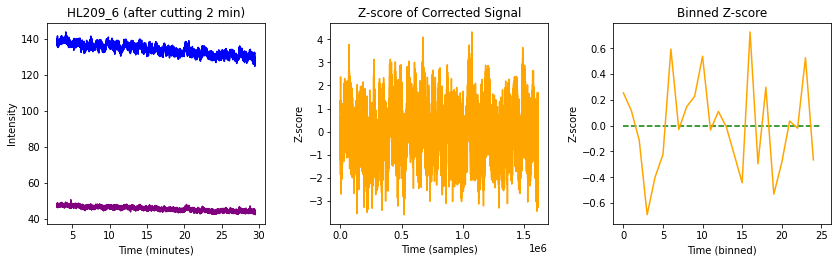

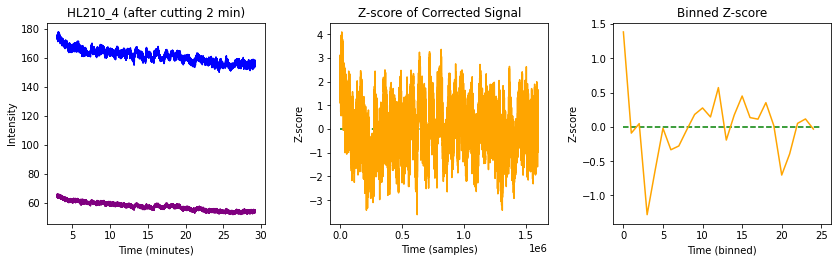

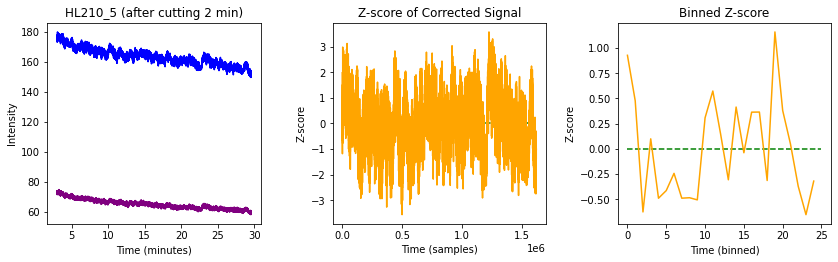

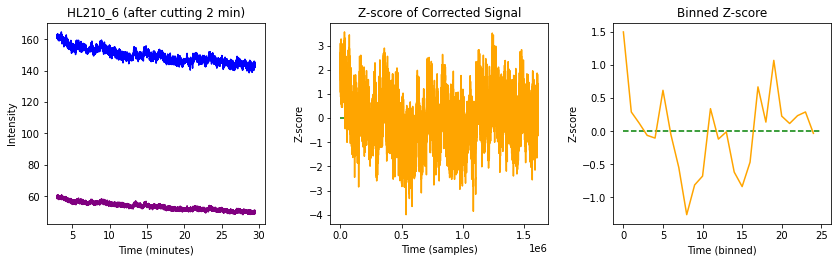

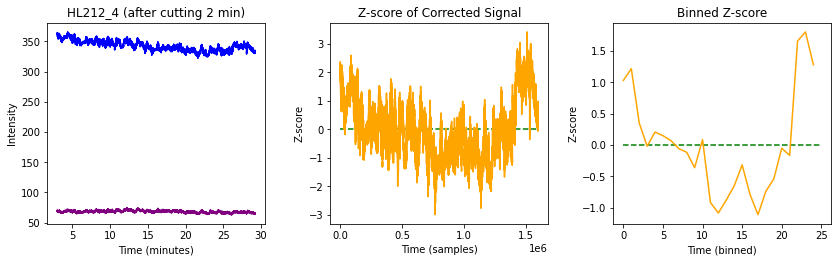

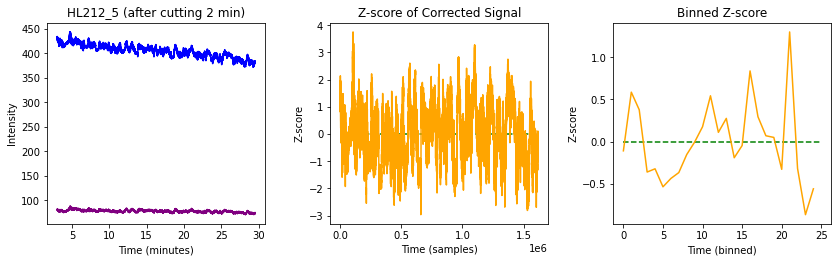

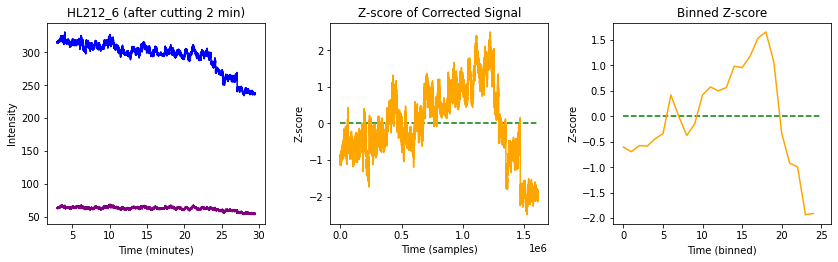

In [119]:
mice = get_list_of_mice(PVH_restricted)

save_dir = FIGSFOLDER

# 2. Iterate through each mouse
for mouse in mice:
    print(f"Processing sessions for mouse {mouse}")
    
    # 3. Retrieve session keys for the current mouse
    session_keys = [key for key, val in PVH_restricted.items() if val["mouse_ID"] == mouse]
    
    # 4. Process each session for this mouse
    for session_key in session_keys:
        print(f"Processing session {session_key}")

        fig = process_session(PVH_restricted, session_key, nbins=25)
        
        figure_filename = f"{session_key}_figure.jpg"
        figure_path = os.path.join(save_dir, figure_filename)

        fig.savefig(figure_path)



In [14]:
mice = get_list_of_mice(VMH_restricted)
print(mice)

['HL302', 'HL303', 'HL307', 'HL309', 'HL310', 'HL311', 'HL312']


Processing sessions for mouse HL302
Processing session HL302_4
Processing session HL302_5
Processing session HL302_6
Processing sessions for mouse HL303
Processing session HL303_4
Processing session HL303_5
Processing session HL303_6
Processing sessions for mouse HL307
Processing session HL307_4
Processing session HL307_5
Processing session HL307_6
Processing sessions for mouse HL309
Processing session HL309_4
Processing session HL309_5
Processing session HL309_6
Processing sessions for mouse HL310
Processing session HL310_4
Processing session HL310_5
Processing session HL310_6
Processing sessions for mouse HL311
Processing session HL311_4
Processing session HL311_5
Processing session HL311_6
Processing sessions for mouse HL312
Processing session HL312_4
Processing session HL312_5
Processing session HL312_6


<ipython-input-7-f36651c0c695>:23: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  f,ax=plt.subplots(figsize=(12,4), ncols=3)


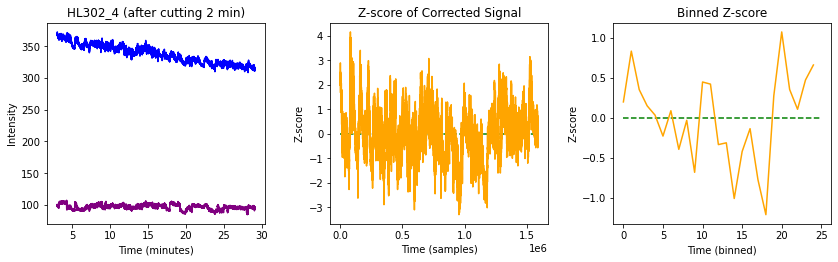

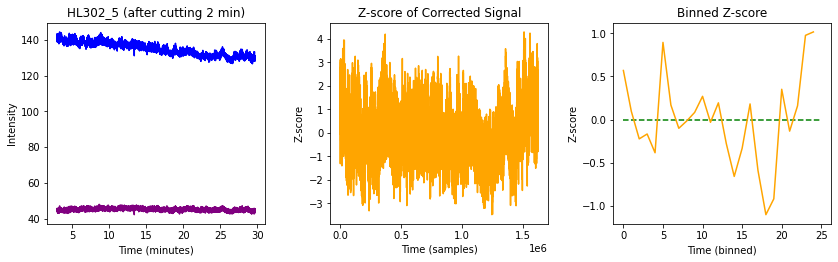

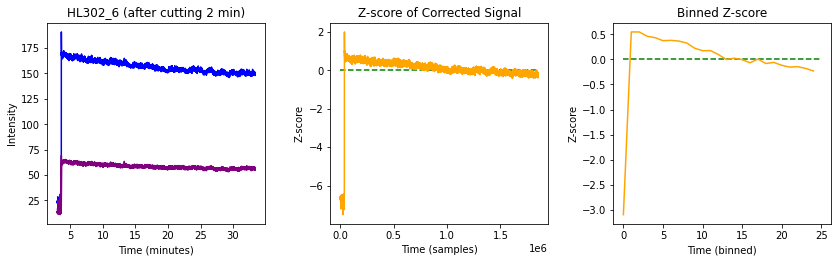

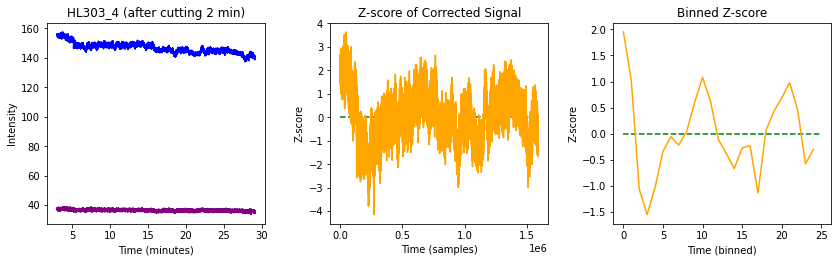

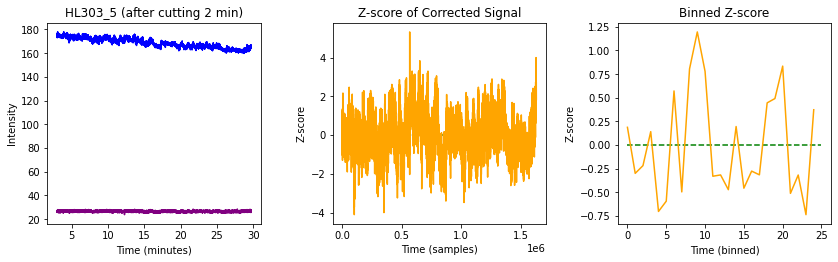

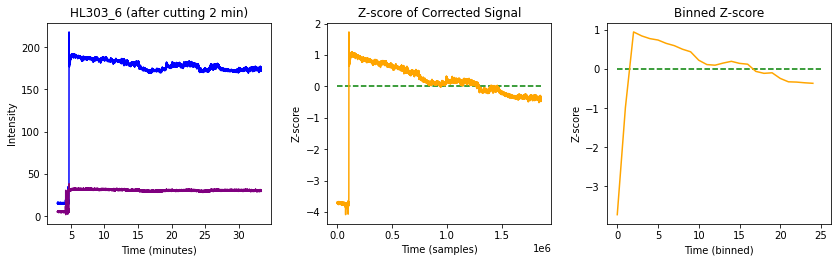

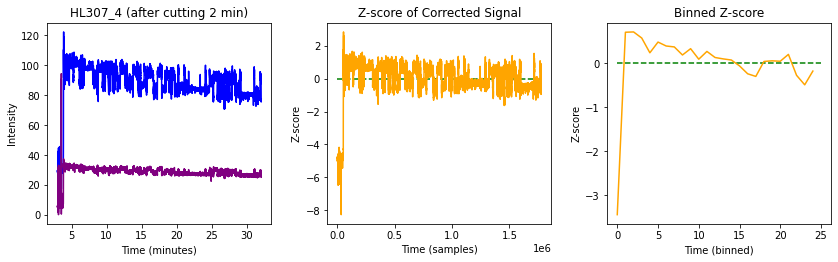

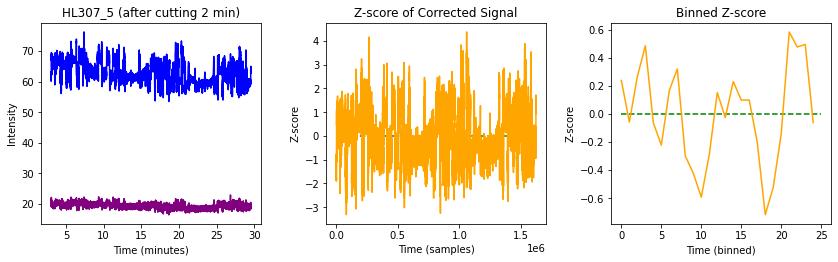

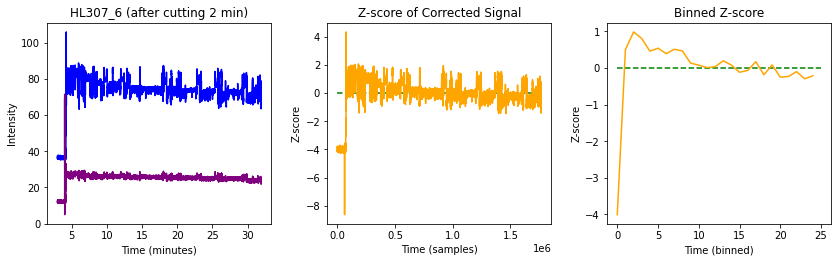

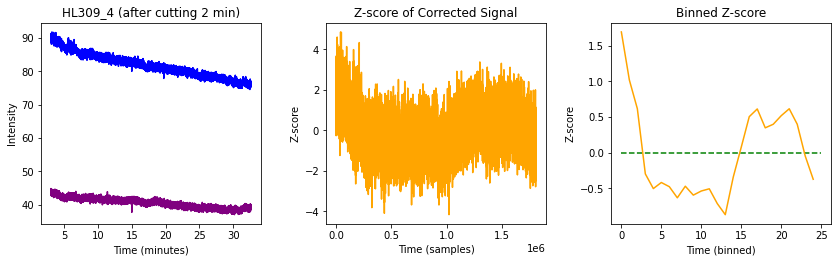

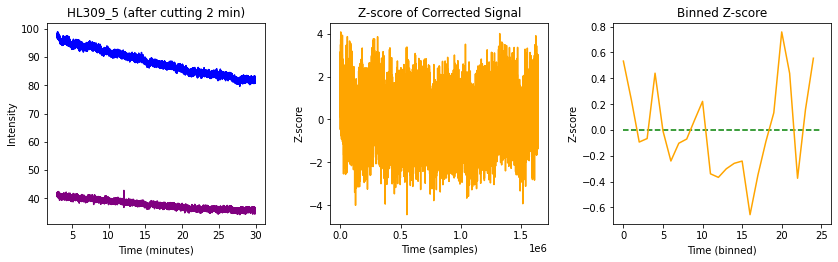

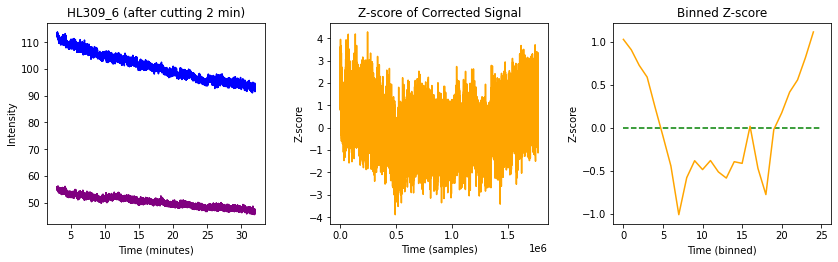

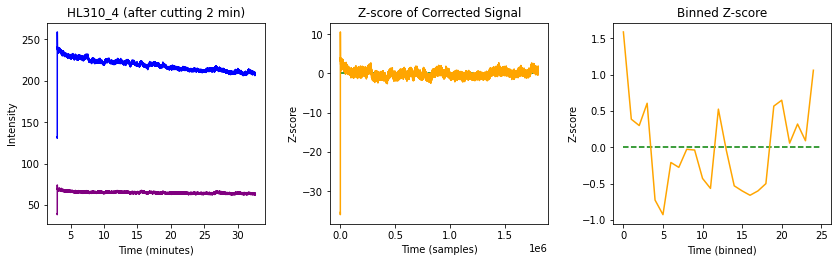

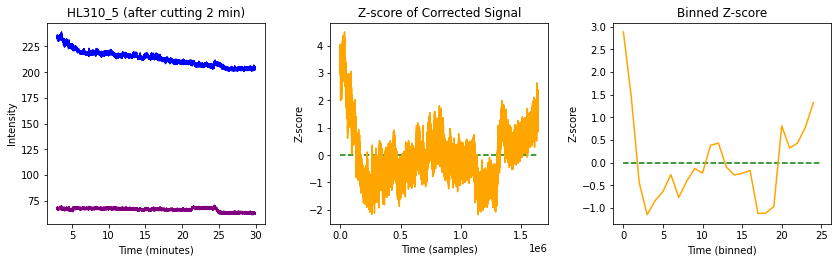

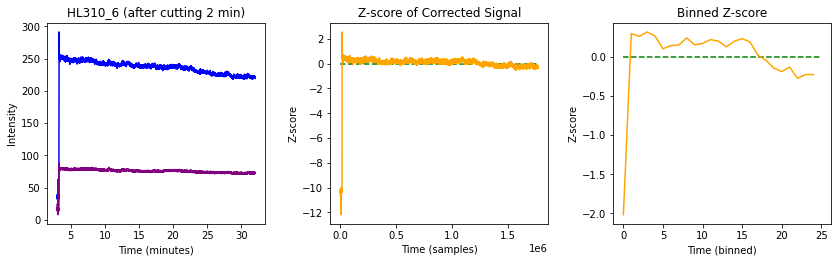

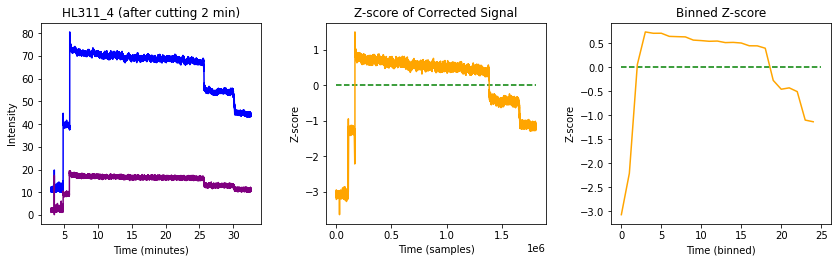

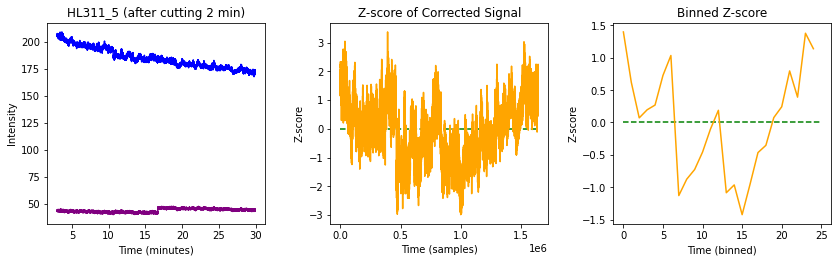

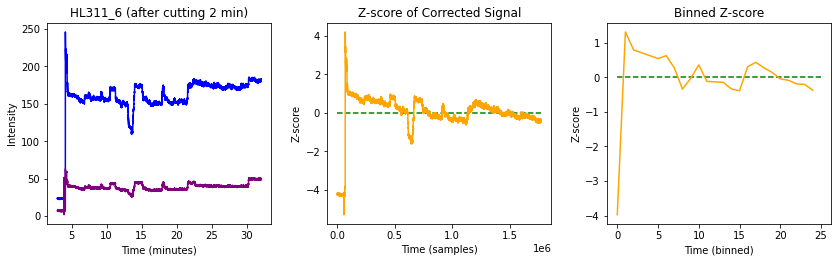

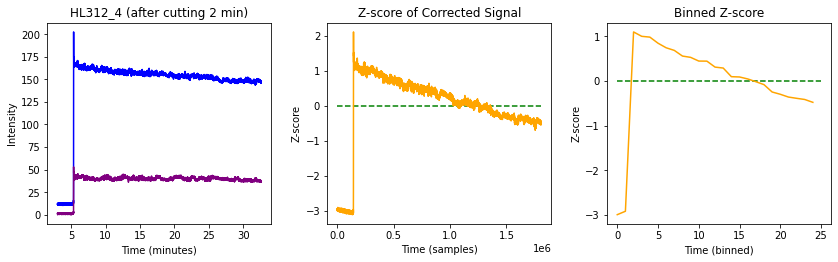

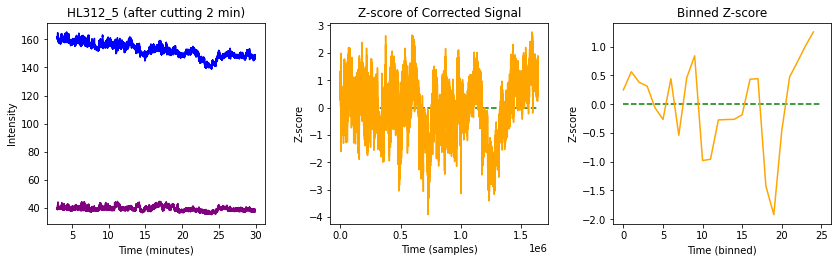

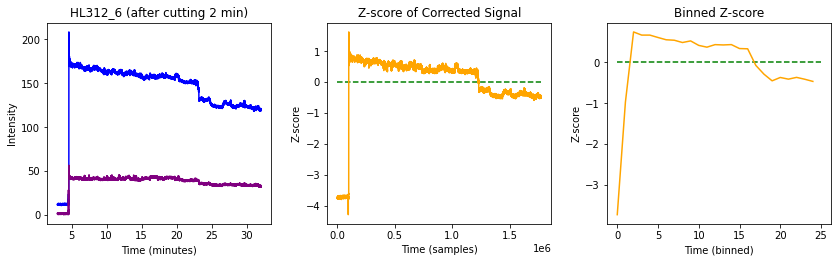

In [17]:
mice = get_list_of_mice(VMH_restricted)

save_dir = FIGSFOLDER

# 2. Iterate through each mouse

for mouse in mice:
    print(f"Processing sessions for mouse {mouse}")
    
    # 3. Retrieve session keys for the current mouse
    session_keys = [key for key, val in VMH_restricted.items() if val["mouse_ID"] == mouse]
    
    # 4. Process each session for this mouse
    for session_key in session_keys:
        print(f"Processing session {session_key}")

        fig = process_session(VMH_restricted, session_key, nbins=25)
        
        figure_filename = f"{session_key}_figure.jpg"
        figure_path = os.path.join(save_dir, figure_filename)

        fig.savefig(figure_path)

